In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [2]:
data = pd.read_csv('conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
data.shape

(316200, 6)

In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [ ]:
# cannot drop duplicates since we are not sure whether points are duplicates or not.

In [27]:
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[0:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     58	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


In [50]:
data.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

# Exploration Data Analysis

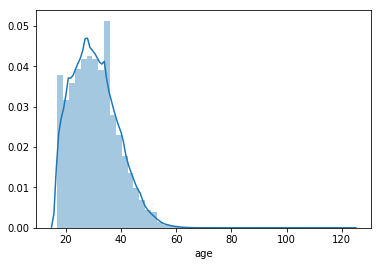

In [6]:
# the distribute of age
sns.distplot(data['age'])

In [7]:
data.loc[data['age'] >=90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [8]:
# the age > 90 is likely to be low probaility event, we should choose data that age < 90
data = data.loc[data['age']<90]
data.shape

(316198, 6)

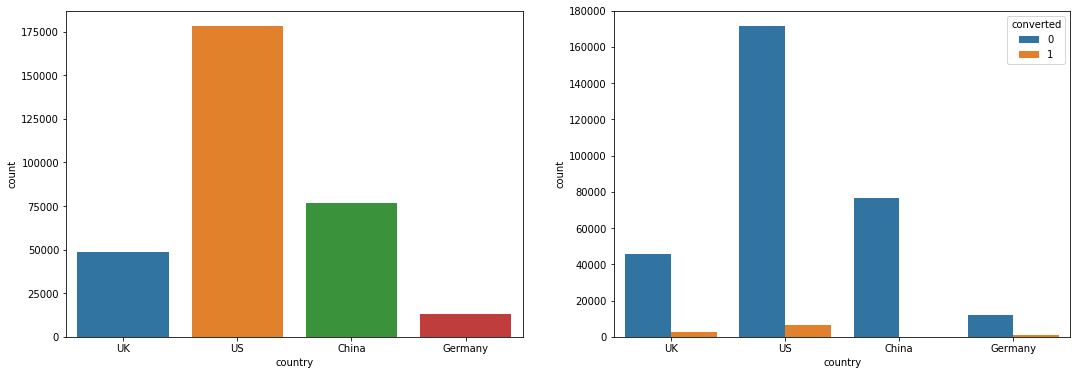

In [9]:
# visualize different countries
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', data = data, ax =ax[0])
sns.countplot(x='country', data = data, hue = 'converted', ax= ax[1])

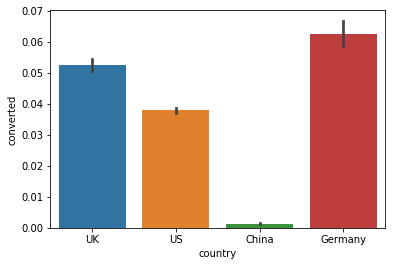

In [10]:
# the converted rate of each country
sns.barplot(x='country', y = 'converted', data = data)

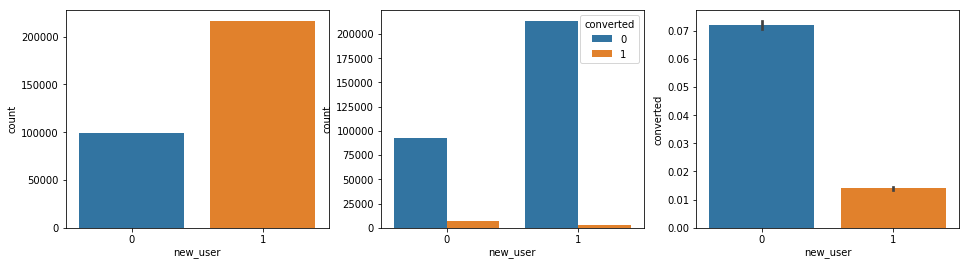

In [11]:
#new_users
fig, ax = plt.subplots(nrows =1, ncols=3, figsize =(16,4))
sns.countplot(x = 'new_user', data= data, ax= ax[0])
sns.countplot(x = 'new_user', data =data, hue = 'converted', ax = ax[1])
sns.barplot(x = 'new_user', y = 'converted', data =data, ax = ax[2])
# the converted rate of old users is higher than that of new users.

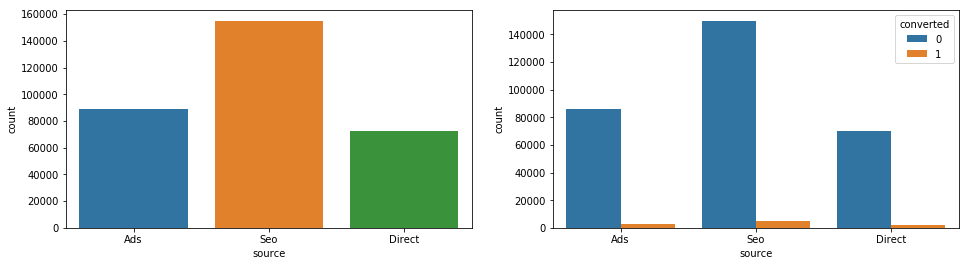

In [12]:
# the source
fig, ax = plt.subplots(nrows =1, ncols=2, figsize =(16,4))
sns.countplot(x = 'source', data= data, ax= ax[0])
sns.countplot(x = 'source', data =data, hue = 'converted', ax = ax[1])

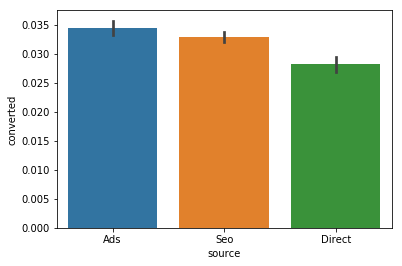

In [13]:
sns.barplot(x = 'source', y = 'converted', data =data)

AttributeError: 'numpy.ndarray' object has no attribute 'legend'

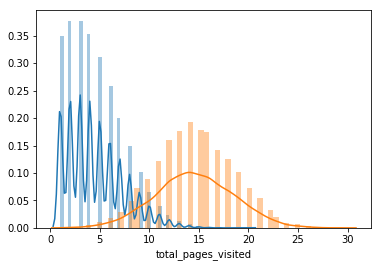

In [37]:
# total_pages_visited
sns.distplot(data.loc[data['converted']==0,'total_pages_visited'])
sns.distplot(data.loc[data['converted']==1,'total_pages_visited'])


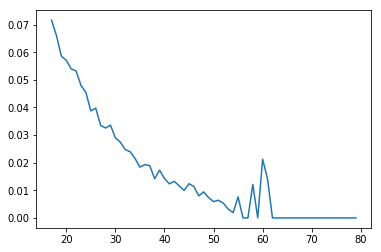

In [38]:
group = data[['age', 'converted']].groupby('age').mean().reset_index()
ax = plt.plot(group['age'], group['converted'])

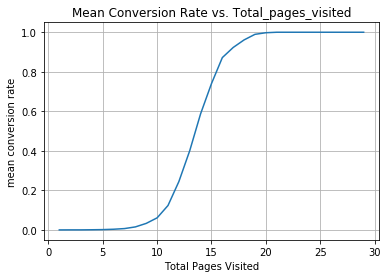

In [46]:
group = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()
ax = plt.plot(group['total_pages_visited'], group['converted'])
plt.title('Mean Conversion Rate vs. Total_pages_visited', fontsize=12)
plt.xlabel('Total Pages Visited', fontsize =10)
plt.ylabel('mean conversion rate', fontsize =10)
plt.grid()

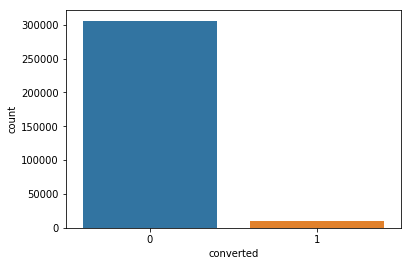

In [51]:
sns.countplot(data['converted'] )

# Machine Learning

In [48]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,30 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,1 month and 4 days
H2O cluster name:,H2O_from_python_yongxin_5dewcl
H2O cluster total nodes:,1
H2O cluster free memory:,3.531 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [49]:
h2o_df = H2OFrame(data)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.5693110013347,,,4.872918234777034,
maxs,,79.0,,,29.0,
sigma,,8.268957596421474,,,3.3410533442156267,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [52]:
#stratified the dataset
strat_split = h2o_df['converted'].stratified_split(test_frac = 0.3, seed =123)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

In [53]:
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=5, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


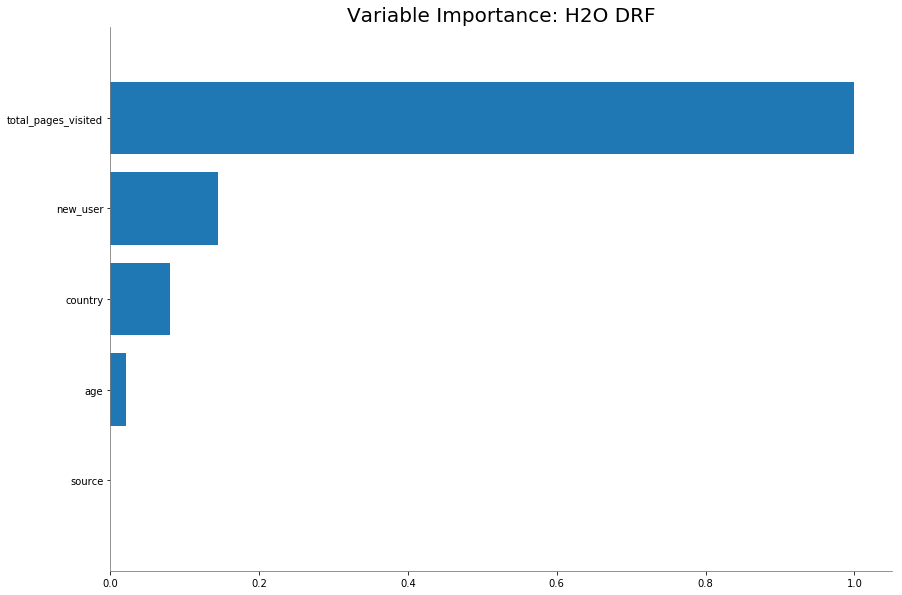

In [54]:
model.varimp_plot()

In [55]:
#make prediction
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [56]:
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     91800
           1       0.88      0.38      0.53      3059

    accuracy                           0.98     94859
   macro avg       0.93      0.69      0.76     94859
weighted avg       0.98      0.98      0.97     94859



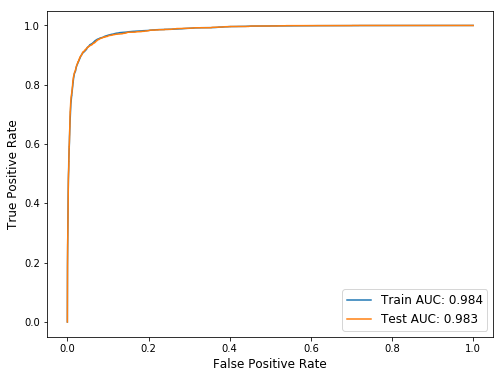

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


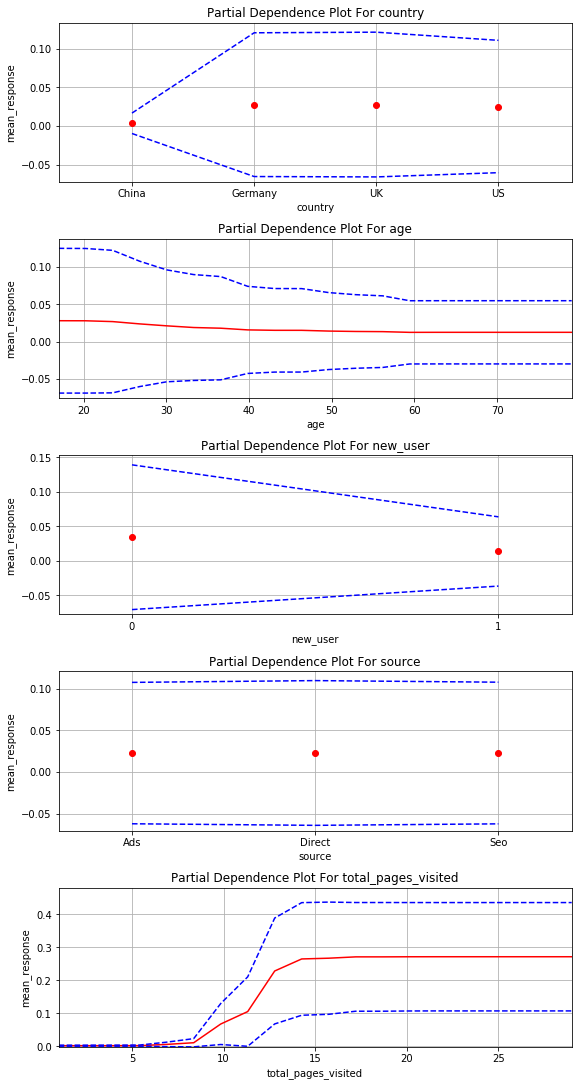

In [58]:
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))

In [59]:
h2o.cluster().shutdown()

H2O session _sid_a726 closed.
